## 1. Import dependencies

This section imports all necessary libraries for data manipulation, NetCDF file handling, geographical data processing, statistical analysis, interactive widgets, and advanced plotting capabilities.

In [10]:
import numpy as np
import netCDF4 as nc
import numpy.ma as ma

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FixedLocator
import matplotlib.patches as patches
import matplotlib.patheffects as pe
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LinearSegmentedColormap as lsc

from IPython.display import display
import ipywidgets as widgets

import geopandas as gpd
from scipy import stats

from utils import palm_variables  # Import custom module from the parent directory

## 2. Import data
This section defines the file paths for the 2D simulation output NetCDF files (for baseline and scenario 1) and the static driver file. These files are then loaded into netCDF4 Dataset objects, making their contents accessible for processing. The buildings_2d data from the static driver is also extracted, which is used for masking non-atmospheric grid cells during data extraction.

In [11]:
# Absolute URL of simulation output files and static driver
file_xy_1 = r"./Data/agg_6_wind\konstanz_4096x4096_v9_Baseline_av_3d_N03_wspeed.nc"
file_xy_2 = r"./Data/agg_6_wind/konstanz_4096x4096_v9_Scenario_1_av_3d_N03_wspeed.nc"
file_xy_ref = r"./Data/_simulation_outputs_3/konstanz_4096x4096_v9_Baseline-48hr/OUTPUT/konstanz_4096x4096_v9_Baseline_av_xy_N03.000.nc"
file_static = r"./Data/INPUT/konstanz_4096x4096_v9_Baseline_static_N03"

# Read netcdf files
dataset_1 = nc.Dataset(file_xy_1, mode='r')
dataset_2 = nc.Dataset(file_xy_2, mode='r')
dataset_ref = nc.Dataset(file_xy_ref, mode='r')
dataset_3 = nc.Dataset(file_static, mode='r')

file_xy_list = [file_xy_1, file_xy_2]
dataset_list = [dataset_1, dataset_2]

# Extract 2D buildings data from the static dataset
buildings_2d = dataset_3['buildings_2d']
buildings_2d_data = buildings_2d[:, :]

## 3. Variable Selection
This section allows the user to interactively select a 2D variable from the loaded NetCDF datasets. A dropdown widget is provided for selection, and the chosen variable's description and unit (retrieved from the palm_variables module) are displayed for clear identification.

In [12]:
# Extract variable names with dimensions greater than 2
var_names_palm = [var for var in dataset_1.variables if dataset_1.variables[var].ndim > 2]

# Extract variables and define test variable
test_variable = var_names_palm[0]

# Create a dropdown widget
drop_down = widgets.Dropdown(
    options=var_names_palm,
    value=var_names_palm[0],
    description='Select test variable:'
)
def dropdown_handler(change):
    global test_variable
    test_variable = change.new
    print(test_variable)

drop_down.observe(dropdown_handler, names='value')
display(drop_down)

Dropdown(description='Select test variable:', options=('wspeed',), value='wspeed')

In [13]:
# Check if "*" is in the test_variable and extract initial variable, unit, and description
if test_variable:
    var_initial = test_variable
    variable_info = palm_variables.variables_dict.get(var_initial, {})
    unit = variable_info.get('unit', 'No unit available')
    description = variable_info.get('description', 'No description available')
    print(f"{description.capitalize()}, {unit}")

Magnitude of the horizontal wind vector, m/s


## 4. Define Time Sequences and Equivalents
This section dynamically extracts the total number of time steps from the loaded dataset. It then defines parameters for time step intervals and calculates sequences and human-readable time equivalents (HH:MM format) for both hourly and all time steps. These sequences are crucial for temporal aggregation and plotting.

In [14]:
# Read total time steps in the NetCDF
variable_data_1 = dataset_1[test_variable]
variable_data_shape = np.shape(variable_data_1)
total_time_steps = variable_data_shape[0]

# Extract time sequence and time equivalent
time_step_interval = 6
if time_step_interval == 3:
    second_step = 2
elif time_step_interval == 6:
    second_step = 5
elif time_step_interval == 1:
    second_step = 1

# Time_sequence for time step and for all time steps
time_sequence = [0]
time_sequence.extend(
    np.arange(second_step, total_time_steps, time_step_interval))
time_sequence_all = range(total_time_steps)

# Function to convert time sequence
def list_to_24hour(time_sequence):
    time_equivalent = []
    time_equivalent_24hr = []
    for time_step in time_sequence:
        total_minutes = (time_step+1)*10
        hours, minutes = divmod(total_minutes, 60)
        time_equivalent.append(f"{hours:02d}:{minutes:02d}")
        if hours <= 24:
            time_equivalent_24hr.append(f"{hours:02d}:{minutes:02d}")
        if hours > 24:
            hours -= 24
            time_equivalent_24hr.append(f"{hours:02d}:{minutes:02d}")

    return time_equivalent, time_equivalent_24hr

time_equivalent, time_equivalent_24hr = list_to_24hour(time_sequence)
time_equivalent_all, time_equivalent_all_24hr = list_to_24hour(time_sequence_all)

## 5. Useful Other

In [15]:
## Useful Other
# Define grid spacing
dx = dataset_ref['x'][1]-dataset_ref['x'][0]
dy = dataset_ref['y'][1]-dataset_ref['y'][0]
# Define number of cells
nx = np.shape(dataset_ref['x'])[0]
ny = np.shape(dataset_ref['y'])[0]

# Coordinates of origin in PALM
origin_x, origin_y, origin_z = dataset_ref.origin_x, dataset_ref.origin_y, dataset_ref.origin_z

# Vector for coordinate at cell edges
x = np.arange(nx+1)*dx + origin_x
y = np.arange(nx+1)*dy + origin_y
# Vector for coordinates at cell centers
xc = np.arange(nx)*dx + origin_x + dx/2
yc = np.arange(nx)*dy + origin_y + dy/2

# Time
origin_time = dataset_ref.origin_time
time_step = 600  # ds.time_step
nt = np.shape(dataset_ref['time'])[0]

In [16]:
def center_yticks(ax):
    # Get the current y-tick positions and labels
    tick_positions = ax.get_yticks()
    tick_labels = [f'{pos:.2f}' for pos in tick_positions]
    # Set the tick positions explicitly using FixedLocator
    ax.yaxis.set_major_locator(FixedLocator(tick_positions))
    # Set the y-tick labels with the correct alignment
    ax.set_yticklabels(tick_labels, rotation=90,
                       verticalalignment='center', fontsize=12)

def get_date_day(time_index):
    if time_index<=144:
        return 14
    elif time_index>144:
        return 15

def get_extents(gdf_combined, location_id, increased_distance):
    polygon_aug = gdf_combined.iloc[location_id]
    polygon = polygon_aug.geometry
    min_x, min_y, max_x, max_y = polygon.bounds
    # Convert geographic coordinates to array indices
    x1, y1, x2, y2 = int((min_x-origin_x)/dx), int((min_y-origin_y) /
                                                   dx), int((max_x-origin_x)/dx), int((max_y-origin_y)/dx)

    # change extents value based on buffer distance
    half_window = int(increased_distance/2)

    x_low, x_high = x1-half_window, x2+half_window
    y_low, y_high = y1-half_window, y2+half_window

    if x_low <= 0:
        x_low = 0
    if y_low <= 0:
        y_low = 0
    if x_high >= 256:
        x_high = 256
    if y_high >= 256:
        y_high = 256
    return (x_low, y_low, x_high, y_high)

In [17]:
def plot_north_arrow_and_scale_bar():
    # Add north arrow
    top_right_x = 513390
    top_right_y = 5278890
    # Add a north arrow at the top right corner of the plot
    arrow = patches.FancyArrowPatch((top_right_x, top_right_y - 40), (top_right_x, top_right_y),
                                    arrowstyle='simple',  linewidth=1.5, mutation_scale=25, color='k')
    ax.text(top_right_x, top_right_y - 50, 'N', fontsize=20, color='k', ha='center', va='center', weight='bold')
    ax.add_patch(arrow)    

    # Add scale bar (location: bottom right corner)
    scale_bar_x = 513250
    scale_bar_y = 5278410
    scale_bar_length_meters = 150  # Length of the scale bar in meters
    scale_bar_segment_length = 50  # Length of each alternating segment in meters
    
    # Create the scale bar as a collection of alternating segments
    num_segments = int(scale_bar_length_meters / scale_bar_segment_length)
    num_labels = num_segments+1
    segment_width = scale_bar_length_meters / num_segments
    for i in range(num_segments):
        if i % 2 == 0:
            segment_color = 'k'  # Black for even segments
        else:
            segment_color = 'w'  # White for odd segments
        segment_x = scale_bar_x + i * segment_width
        scale_bar_segment = patches.Rectangle((segment_x, scale_bar_y), segment_width, 15, linewidth=1, edgecolor='w', facecolor=segment_color)
        ax.add_patch(scale_bar_segment)
    
    for i in range(num_labels):
        # Add a label to the scale bar with a white border
        scale_bar_label = f'{i*scale_bar_length_meters}m'
        text_x = scale_bar_x + scale_bar_segment_length * i
        text_y = scale_bar_y + 25
        ax.text(text_x, text_y, scale_bar_label, fontsize=10, ha='center', color='k', weight='bold',
            bbox=dict(facecolor='white', edgecolor='white', boxstyle='round, pad=0.1'))

### Extract variable data and select domain

In [19]:
variable_data_1 = dataset_1[test_variable]
variable_data_2 = dataset_2[test_variable]
variable_datas = [variable_data_1, variable_data_2]
sim_scenarions = ['Baseline (BS)', 'Scenario 1 (S1)']
sim_scene = ['BS', 'S1']

# Read shapefile
shapefile_path_child_ii = r"C:\Users\ShaileshShrestha\OneDrive - str.ucture GmbH\CoKLIMAx\_Palm_DataPreparation\_Vector\0_AOI\03_AOI_Child_II.shp"
shapefile_path_uhi_study = r"./Data/shapefiles/UHI_aoi_study_fitted.shp"

gdf_child = gpd.read_file(shapefile_path_child_ii)
gdf_uhi = gpd.read_file(shapefile_path_uhi_study)

gdf_combined = gpd.pd.concat([gdf_child, gdf_uhi], ignore_index=True)
location_name_list = ['Overall', 'Stephansplatz', 'Markstaette', 'Augustinerplatz']
aoi_name_list = ['Overall', 'AOI1', 'AOI2', 'AOI3']

In [23]:
global value_maximum, value_minimum
value_maximum = 0
value_minimum = 999999

for time_index_test in time_sequence:
    value_test_1 = variable_data_1[time_index_test, 0, :, :]
    value_test_1.mask = ~buildings_2d_data.mask

    value_test_2 = variable_data_2[time_index_test, 0, :, :]
    value_test_2.mask = ~buildings_2d_data.mask

    max_value_test = max(np.nanmax(value_test_1), np.nanmax(value_test_2))
    min_value_test = min(np.nanmin(value_test_1), np.nanmin(value_test_2))

    if value_maximum <= max_value_test:
        value_maximum = max_value_test
    if value_minimum >= min_value_test:
        value_minimum = min_value_test

print(value_maximum, value_minimum)

3.7206812 0.0010265734


### Perform ttest at individual pixel

In [24]:
band_values1 = variable_data_1[:, 0, :, :]
band_values2 = variable_data_2[:, 0, :, :]

band_shape = np.shape(band_values1)

In [25]:
start_time_day = '05:20'
end_time_day = '21:20'

start_time_day = '12:00'
end_time_day = '18:00'

start_time_night = '21:30'
end_time_night = '29:10'

# ----------------------
start_day_1 = time_sequence_all[time_equivalent_all.index(start_time_day)]
end_day_1 = time_sequence_all[time_equivalent_all.index(end_time_day)]

start_day_2 = time_sequence_all[time_equivalent_all.index(f"{int(start_time_day[:2])+24}:{start_time_day[-2:]}")]
end_day_2 = time_sequence_all[time_equivalent_all.index(f"{int(end_time_day[:2])+24}:{end_time_day[-2:]}")]

start_night_1 = time_sequence_all[time_equivalent_all.index(start_time_night)]
end_night_1 = time_sequence_all[time_equivalent_all.index(end_time_night)]

In [26]:
start_day_1, end_day_1, start_night_1, end_night_1, start_day_2, end_day_2,

(71, 107, 128, 174, 215, 251)

In [27]:
list_day_1 = list(range(start_day_1,end_day_1+1))
list_day_2 = list(range(start_day_2,end_day_2+1))

list_night_1 = list(range(start_night_1,end_night_1+1))

print(list_day_1)
print(list_day_2)
print(list_night_1)

[71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107]
[215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251]
[128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174]


### Compute mean values

In [28]:
values_temp_day1_bs = []
values_temp_day1_s1 = []

values_temp_day2_bs = []
values_temp_day2_s1 = []

values_temp_night1_bs = []
values_temp_night1_s1 = []

for time_index_temp in list_day_1:
    values_temp_day1_bs.append(band_values1[time_index_temp,:,:].filled(0))
    values_temp_day1_s1.append(band_values2[time_index_temp,:,:].filled(0))
    
for time_index_temp in list_day_2:
    values_temp_day2_bs.append(band_values1[time_index_temp,:,:].filled(0))
    values_temp_day2_s1.append(band_values2[time_index_temp,:,:].filled(0))
    
for time_index_temp in list_night_1:
    values_temp_night1_bs.append(band_values1[time_index_temp,:,:].filled(0))
    values_temp_night1_s1.append(band_values2[time_index_temp,:,:].filled(0))

# Convert lists to numpy arrays
values_temp_day1_bs = np.array(values_temp_day1_bs)
values_temp_day1_s1 = np.array(values_temp_day1_s1)

values_temp_day2_bs = np.array(values_temp_day2_bs)
values_temp_day2_s1 = np.array(values_temp_day2_s1)

values_temp_night1_bs = np.array(values_temp_night1_bs)
values_temp_night1_s1 = np.array(values_temp_night1_s1)

# Calculate mean values
mean_values_temp_day1_bs = np.mean(values_temp_day1_bs, axis=0)
mean_values_temp_day1_s1 = np.mean(values_temp_day1_s1, axis=0)

mean_values_temp_day2_bs = np.mean(values_temp_day2_bs, axis=0)
mean_values_temp_day2_s1 = np.mean(values_temp_day2_s1, axis=0)

mean_values_temp_night1_bs = np.mean(values_temp_night1_bs, axis=0)
mean_values_temp_night1_s1 = np.mean(values_temp_night1_s1, axis=0)

## Prepare for plot

In [29]:
list_to_plot = [mean_values_temp_day1_bs, mean_values_temp_day1_s1]
list_to_plot_masked = [ma.array(list_to_plot[0], mask=~buildings_2d_data.mask),
                       ma.array(list_to_plot[1], mask=~buildings_2d_data.mask)]

list_of_titles = ['BS, 2023-06-14 +01', 'S1, 2023-06-14 +01']

value_max = max(np.nanmax(list_to_plot_masked[0]), np.nanmax(list_to_plot_masked[1]))
value_min = min(np.nanmin(list_to_plot_masked[0]), np.nanmin(list_to_plot_masked[1]))

print(value_max, value_min)
interal_temp = 0.25

vmin = ma.floor(value_min)
vmax = ma.ceil(value_max)

count_interval = int((vmax-vmin)/interal_temp)
print(vmin, vmax, count_interval)

1.8819546 0.0056325365
0.0 2.0 8


In [30]:
from matplotlib.colors import LinearSegmentedColormap

colors = ["#26acff", "yellow", "red"]
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

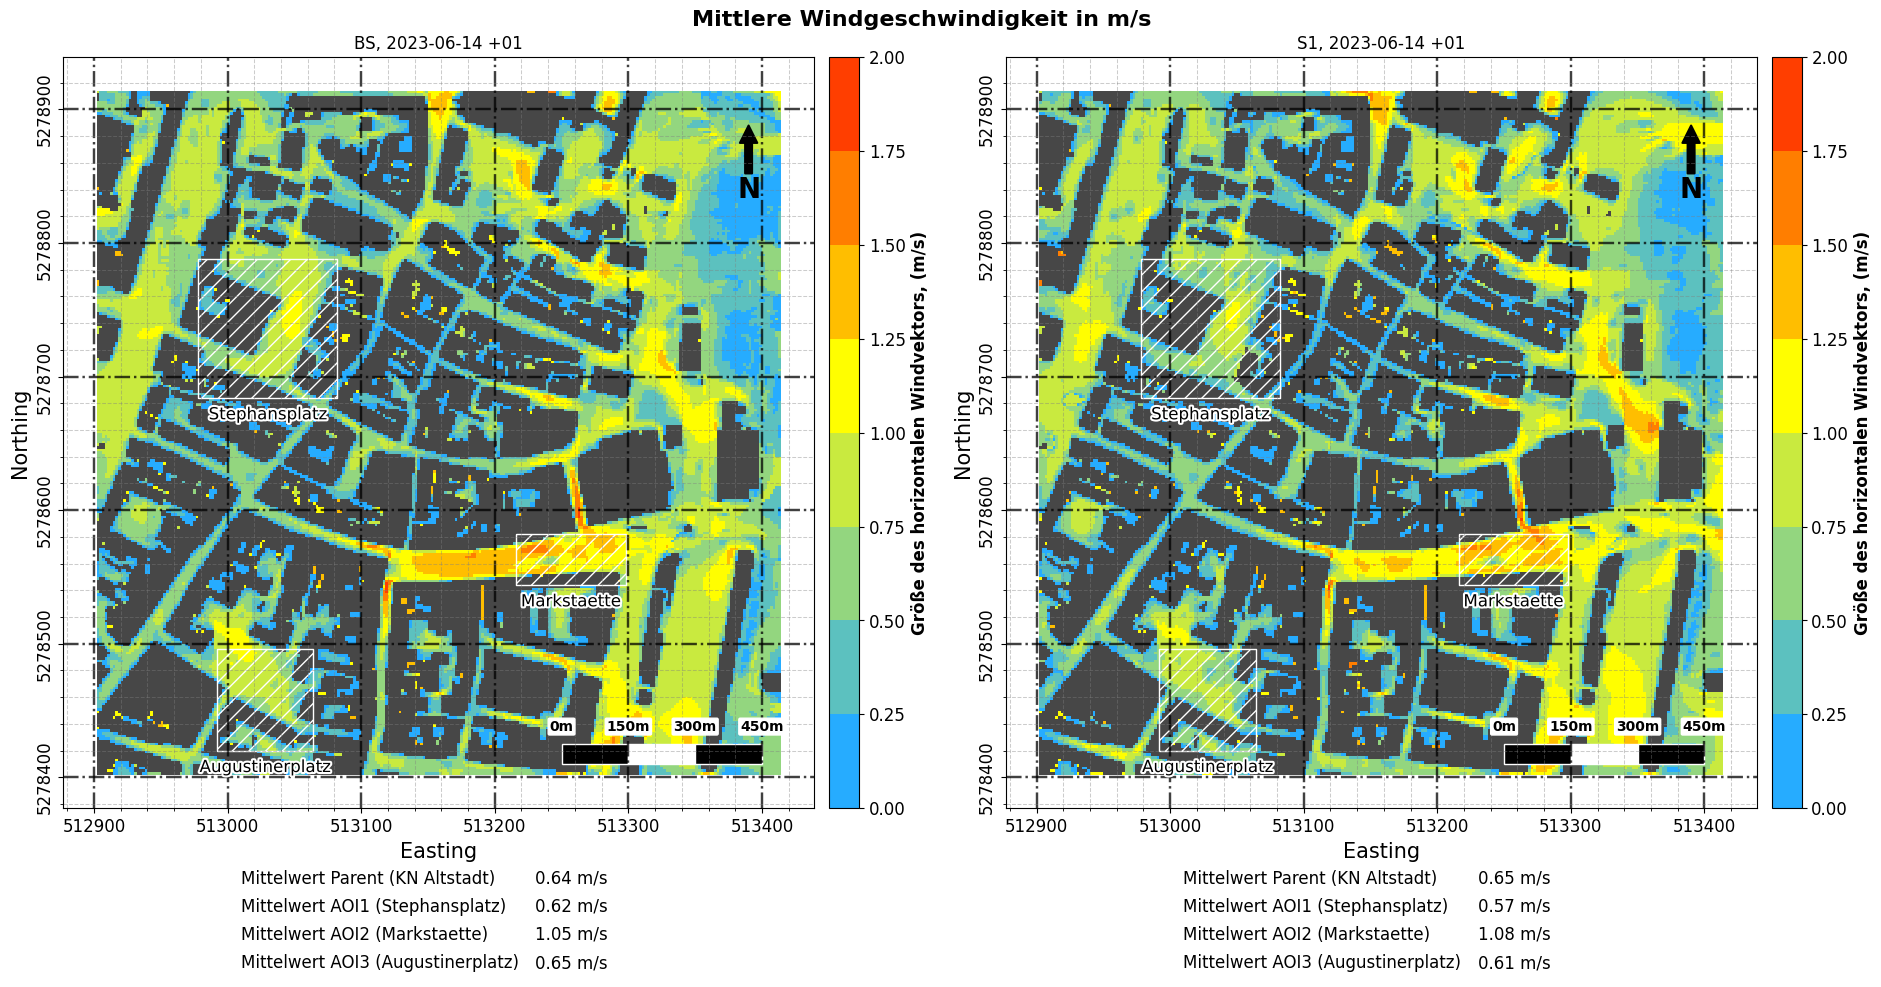

In [31]:
# Plotting the masked t_test_results using a heatmap
fig, axs = plt.subplots(1,2, figsize=(19, 9), facecolor='w', edgecolor='k')
fig.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.rcParams.update({'font.size': 15})

for i, variable_data in enumerate(list_to_plot_masked):
    ax = axs[i]
    plt.suptitle(f"Mittlere Windgeschwindigkeit in {unit}", fontsize=16, weight='bold')
    
    # Define plot color and mask color
    cmap = plt.get_cmap('jet')  # Other cmap: jet, turbo, rainbow,
    cmap.set_bad('#474747')  # 474747

    # Define qualitative from sequential cmap
    num_colors = count_interval
    sequential_cmap = custom_cmap #plt.get_cmap('turbo')
    colors = [sequential_cmap(i / num_colors) for i in range(num_colors)]
    qualitative_cmap = plt.cm.colors.ListedColormap(colors)
    qualitative_cmap.set_bad('#474747')

    pcm = ax.pcolormesh(x,y, variable_data, cmap=qualitative_cmap, vmin=vmin, vmax=vmax)
    
    # Compute statistics
    values = variable_data[:,:]
    
    buffer_distance = half_window_2 = 10
    # Plot shapefile and calculate mean within each polygon
    buffered_gdf = gdf_uhi.copy()
    buffered_gdf['geometry'] = buffered_gdf['geometry'].buffer(buffer_distance, join_style=2)
    buffered_gdf.plot(ax=ax, color='none', edgecolor='w', linewidth=1.0, alpha=1, hatch='//')

    aoi_uhi_mean = []
    for index, row in gdf_uhi.iterrows():
        polygon = row.geometry
        min_x, min_y, max_x, max_y = polygon.bounds
        x1, y1, x2, y2 = int((min_x-origin_x)/dx), int((min_y-origin_y)/dx), int((max_x-origin_x)/dx), int((max_y-origin_y)/dx)

        half_window = half_window_2
        value_mean_polygon = values[y1-half_window:y2+half_window, x1-half_window:x2+half_window]
        aoi_uhi_mean.append(value_mean_polygon)
        
        ax.annotate(row['Location'], 
            xy=(polygon.centroid.x, min_y), 
            xytext=(0,-25), 
            textcoords="offset points", 
            ha='center', 
            fontsize=12,
            path_effects=[pe.withStroke(linewidth=3, foreground='white')])

    ax.grid(True, linestyle='-.', linewidth=1.75, color='k', alpha=0.75)
    ax.set_xlabel('Easting', fontsize=15)
    ax.set_ylabel('Northing', fontsize=15)
    ax.set_aspect(1)  # 1 or 'equal'

    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
    ax.xaxis.grid(which='minor', linestyle='--', linewidth=0.75, color='grey', alpha=0.4)
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
    ax.yaxis.grid(which='minor', linestyle='--', linewidth=0.75, color='grey', alpha=0.4)

    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelrotation=90, labelsize=12, )
    center_yticks(ax)

    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: f'{y:.0f}'))
    ax.set_title(f"{list_of_titles[i]}", fontsize=12)
    ax.set_xlim(x[0]-25, x[-1]+25)
    ax.set_ylim(y[0]-25, y[-1]+25)

    # Create color bar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="4%", pad=0.15)
    cb = fig.colorbar(pcm, cax=cax, extend=None, format='%.2f', spacing='uniform', )
    cb.ax.tick_params(labelsize=12, rotation=0)
    cb.ax.xaxis.set_ticks_position("top")
    cb.ax.set_ylabel(f"Größe des horizontalen Windvektors, ({unit})", fontsize=12, weight="bold")
    # locator = MultipleLocator(5)
    cb.ax.yaxis.set_major_locator(ticker.LinearLocator(numticks=count_interval+1))
    # cb.ax.tick_params(rotation=90)
    # center_yticks(cb.ax)

    # Create a table
    table_data = [
        ["Mittelwert Parent (KN Altstadt)", f"{np.nanmean(values):.2f} {unit}"],
        [f"Mittelwert AOI1 ({location_name_list[1]})",
         f"{np.nanmean(aoi_uhi_mean[0]):.2f} {unit}"],
        [f"Mittelwert AOI2 ({location_name_list[2]})",
         f"{np.nanmean(aoi_uhi_mean[1]):.2f} {unit}"],
        [f"Mittelwert AOI3 ({location_name_list[3]})",
         f"{np.nanmean(aoi_uhi_mean[2]):.2f} {unit}"]
    ]
    table = ax.table(cellText=table_data,
                     loc='bottom',
                     cellLoc='left',
                     colWidths=[0.45, 0.2],
                     edges='open',
                     bbox=[0.195, -0.225, 0.6, 0.15],)  # xmin, ymin, width, height
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    
    plot_north_arrow_and_scale_bar()
plt.show()

### Plot day 2

In [32]:
list_to_plot = [mean_values_temp_day2_bs, mean_values_temp_day2_s1]
list_to_plot_masked = [ma.array(list_to_plot[0], mask=~buildings_2d_data.mask),
                       ma.array(list_to_plot[1], mask=~buildings_2d_data.mask)]

list_of_titles = ['BS, 2023-06-15 +01', 'S1, 2023-06-15 +01']

value_max = max(np.nanmax(list_to_plot_masked[0]), np.nanmax(list_to_plot_masked[1]))
value_min = min(np.nanmin(list_to_plot_masked[0]), np.nanmin(list_to_plot_masked[1]))

print(value_max, value_min)
interal_temp = 0.25

vmin = ma.floor(value_min)
vmax = ma.ceil(value_max)

count_interval = int((vmax-vmin)/interal_temp)
print(vmin, vmax, count_interval)

1.8966969 0.0060277632
0.0 2.0 8


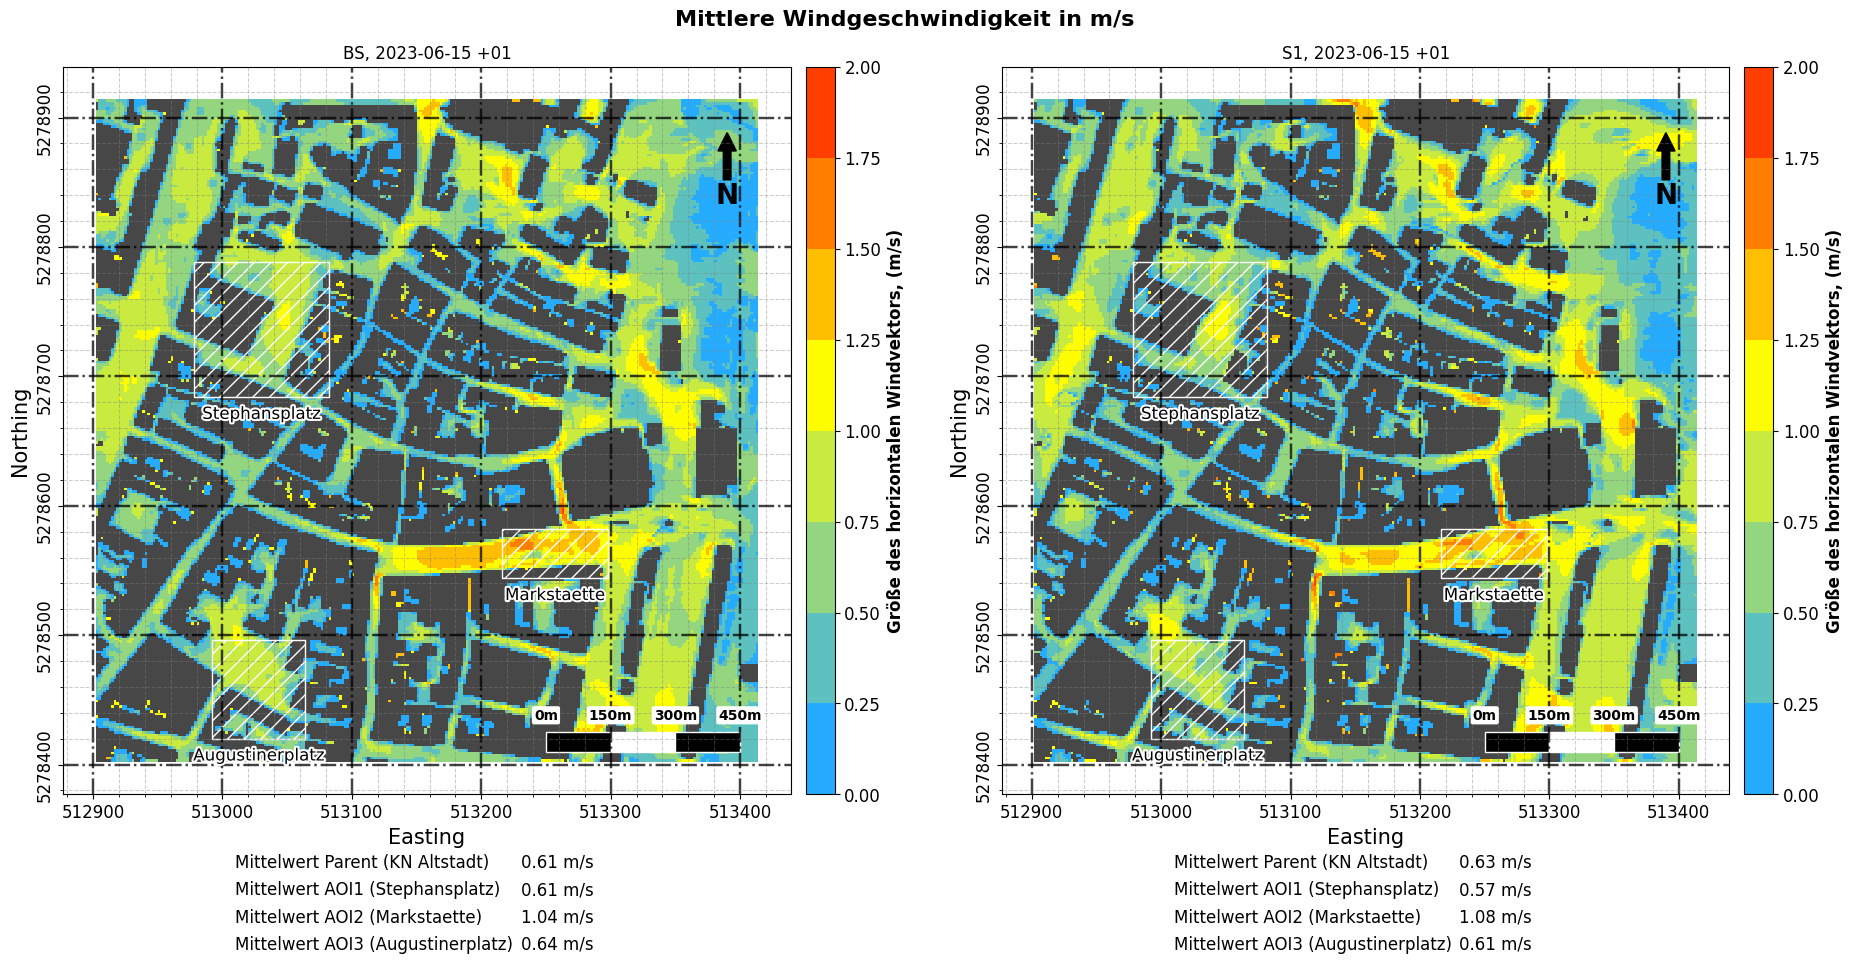

In [33]:
# Plotting the masked t_test_results using a heatmap
fig, axs = plt.subplots(1,2, figsize=(19, 9), facecolor='w', edgecolor='k')
fig.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.rcParams.update({'font.size': 15})

for i, variable_data in enumerate(list_to_plot_masked):
    ax = axs[i]
    plt.suptitle(f"Mittlere Windgeschwindigkeit in {unit}", fontsize=16, weight='bold')

    # Define plot color and mask color
    cmap = plt.get_cmap('jet')  # Other cmap: jet, turbo, rainbow,
    cmap.set_bad('#474747')  # 474747

    # Define qualitative from sequential cmap
    num_colors = count_interval
    sequential_cmap = custom_cmap #plt.get_cmap('turbo')
    colors = [sequential_cmap(i / num_colors) for i in range(num_colors)]
    qualitative_cmap = plt.cm.colors.ListedColormap(colors)
    qualitative_cmap.set_bad('#474747')

    pcm = ax.pcolormesh(x,y, variable_data, cmap=qualitative_cmap, vmin=vmin, vmax=vmax)
    
    # Compute statistics
    values = variable_data[:,:]
    
    buffer_distance = half_window_2 = 10
    # Plot shapefile and calculate mean within each polygon
    buffered_gdf = gdf_uhi.copy()
    buffered_gdf['geometry'] = buffered_gdf['geometry'].buffer(buffer_distance, join_style=2)
    buffered_gdf.plot(ax=ax, color='none', edgecolor='w', linewidth=1.0, alpha=1, hatch='//')

    aoi_uhi_mean = []
    for index, row in gdf_uhi.iterrows():
        polygon = row.geometry
        min_x, min_y, max_x, max_y = polygon.bounds
        x1, y1, x2, y2 = int((min_x-origin_x)/dx), int((min_y-origin_y)/dx), int((max_x-origin_x)/dx), int((max_y-origin_y)/dx)

        half_window = half_window_2
        value_mean_polygon = values[y1-half_window:y2+half_window, x1-half_window:x2+half_window]
        aoi_uhi_mean.append(value_mean_polygon)
        
        ax.annotate(row['Location'], 
            xy=(polygon.centroid.x, min_y), 
            xytext=(0,-25), 
            textcoords="offset points", 
            ha='center', 
            fontsize=12,
            path_effects=[pe.withStroke(linewidth=3, foreground='white')])

    ax.grid(True, linestyle='-.', linewidth=1.75, color='k', alpha=0.75)
    ax.set_xlabel('Easting', fontsize=15)
    ax.set_ylabel('Northing', fontsize=15)
    ax.set_aspect(1)  # 1 or 'equal'

    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
    ax.xaxis.grid(which='minor', linestyle='--', linewidth=0.75, color='grey', alpha=0.4)
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
    ax.yaxis.grid(which='minor', linestyle='--', linewidth=0.75, color='grey', alpha=0.4)

    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelrotation=90, labelsize=12, )
    center_yticks(ax)

    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: f'{y:.0f}'))
    ax.set_title(f"{list_of_titles[i]}", fontsize=12)
    ax.set_xlim(x[0]-25, x[-1]+25)
    ax.set_ylim(y[0]-25, y[-1]+25)

    # Create color bar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="4%", pad=0.15)
    cb = fig.colorbar(pcm, cax=cax, extend=None, format='%.2f', spacing='uniform', )
    cb.ax.tick_params(labelsize=12, rotation=0)
    cb.ax.xaxis.set_ticks_position("top")
    cb.ax.set_ylabel(f"Größe des horizontalen Windvektors, ({unit})", fontsize=12, weight="bold")
    # locator = MultipleLocator(5)
    cb.ax.yaxis.set_major_locator(ticker.LinearLocator(numticks=count_interval+1))
    # cb.ax.tick_params(rotation=90)
    # center_yticks(cb.ax)

    # Create a table
    table_data = [
        ["Mittelwert Parent (KN Altstadt)", f"{np.nanmean(values):.2f} {unit}"],
        [f"Mittelwert AOI1 ({location_name_list[1]})",
         f"{np.nanmean(aoi_uhi_mean[0]):.2f} {unit}"],
        [f"Mittelwert AOI2 ({location_name_list[2]})",
         f"{np.nanmean(aoi_uhi_mean[1]):.2f} {unit}"],
        [f"Mittelwert AOI3 ({location_name_list[3]})",
         f"{np.nanmean(aoi_uhi_mean[2]):.2f} {unit}"]
    ]
    table = ax.table(cellText=table_data,
                     loc='bottom',
                     cellLoc='left',
                     colWidths=[0.45, 0.2],
                     edges='open',
                     bbox=[0.195, -0.225, 0.6, 0.15],)  # xmin, ymin, width, height
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    
    plot_north_arrow_and_scale_bar()
plt.show()

### Plot night1

In [34]:
list_to_plot = [mean_values_temp_night1_bs, mean_values_temp_night1_s1]
list_to_plot_masked = [ma.array(list_to_plot[0], mask=~buildings_2d_data.mask),
                       ma.array(list_to_plot[1], mask=~buildings_2d_data.mask)]

list_of_titles = ['BS, 2023-06-14/15 +01', 'S1, 2023-06-14/15 +01']

value_max = max(np.nanmax(list_to_plot_masked[0]), np.nanmax(list_to_plot_masked[1]))
value_min = min(np.nanmin(list_to_plot_masked[0]), np.nanmin(list_to_plot_masked[1]))

print(value_max, value_min)
interal_temp = 0.2

vmin = ma.floor(value_min)
vmax = ma.ceil(value_max)

count_interval = int((vmax-vmin)/interal_temp)
print(vmin, vmax, count_interval)

0.9359376 0.004736554
0.0 1.0 5


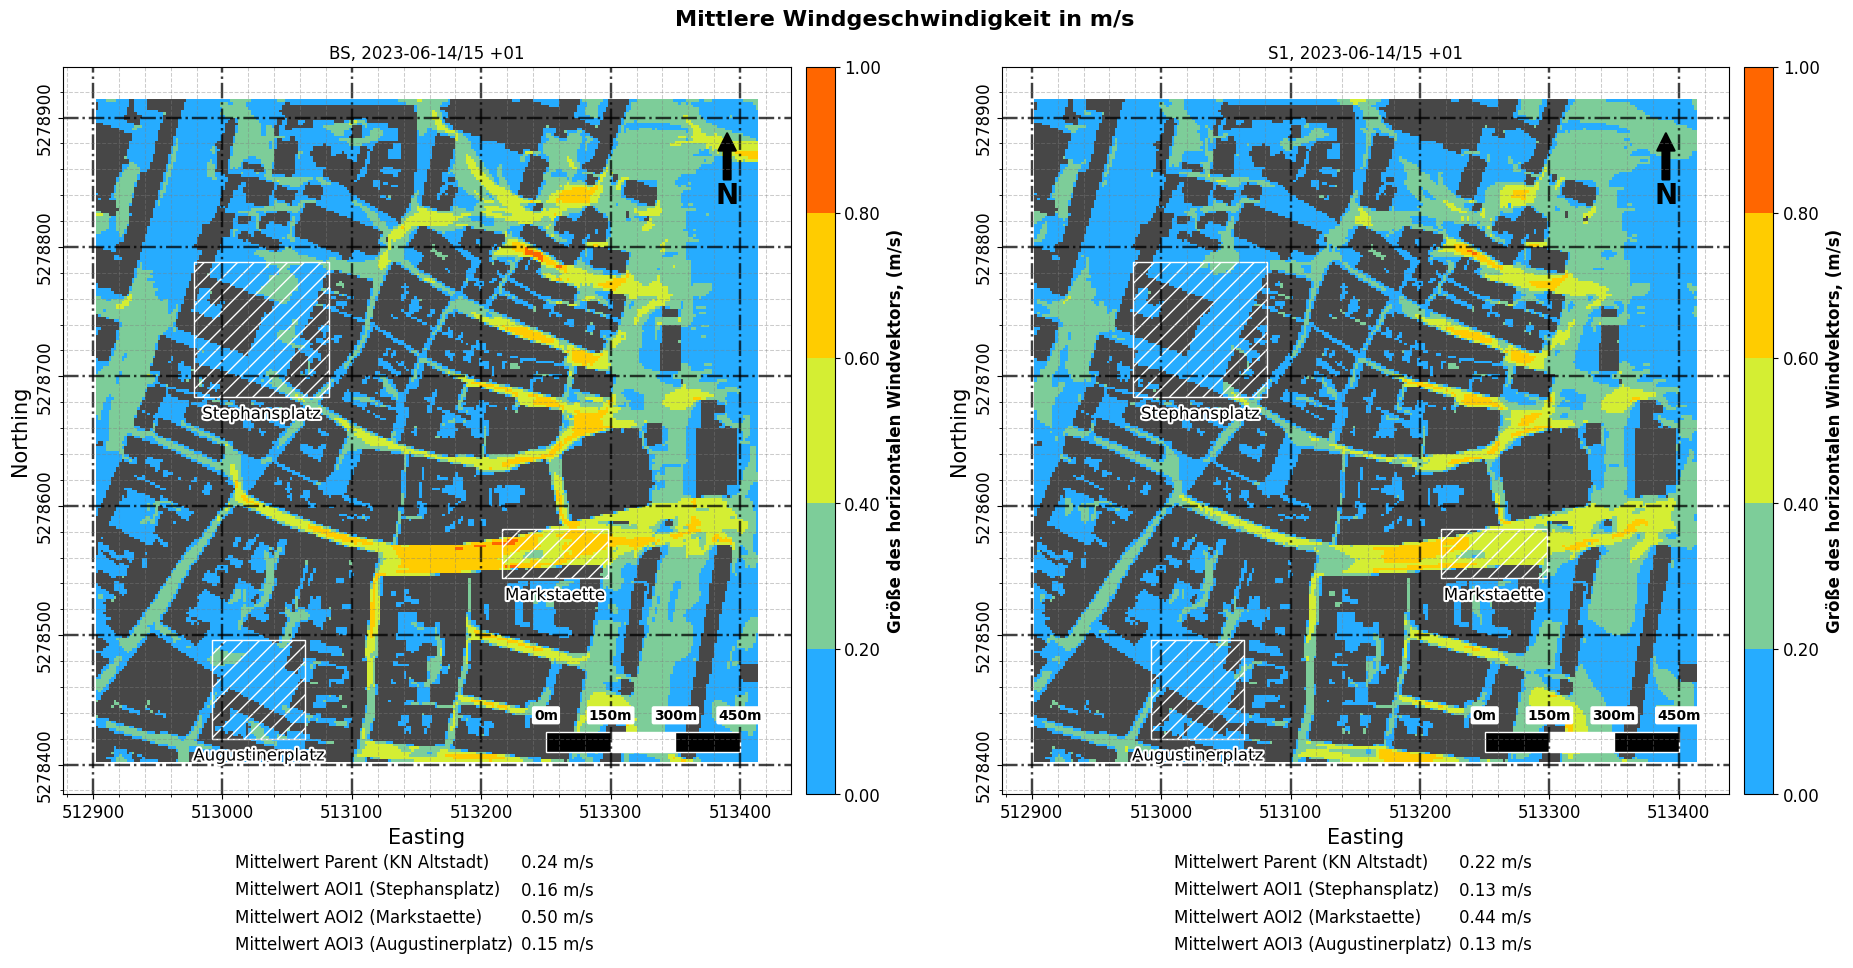

In [35]:
# Plotting the masked t_test_results using a heatmap
fig, axs = plt.subplots(1,2, figsize=(19, 9), facecolor='w', edgecolor='k')
fig.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.rcParams.update({'font.size': 15})

for i, variable_data in enumerate(list_to_plot_masked):
    ax = axs[i]
    plt.suptitle(f"Mittlere Windgeschwindigkeit in {unit}", fontsize=16, weight='bold')

    # Define plot color and mask color
    cmap = plt.get_cmap('jet')  # Other cmap: jet, turbo, rainbow,
    cmap.set_bad('#474747')  # 474747

    # Define qualitative from sequential cmap
    num_colors = count_interval
    sequential_cmap = custom_cmap #plt.get_cmap('turbo')
    colors = [sequential_cmap(i / num_colors) for i in range(num_colors)]
    qualitative_cmap = plt.cm.colors.ListedColormap(colors)
    qualitative_cmap.set_bad('#474747')

    pcm = ax.pcolormesh(x,y, variable_data, cmap=qualitative_cmap, vmin=vmin, vmax=vmax)
    
    # Compute statistics
    values = variable_data[:,:]
    
    buffer_distance = half_window_2 = 10
    # Plot shapefile and calculate mean within each polygon
    buffered_gdf = gdf_uhi.copy()
    buffered_gdf['geometry'] = buffered_gdf['geometry'].buffer(buffer_distance, join_style=2)
    buffered_gdf.plot(ax=ax, color='none', edgecolor='w', linewidth=1.0, alpha=1, hatch='//')

    aoi_uhi_mean = []
    for index, row in gdf_uhi.iterrows():
        polygon = row.geometry
        min_x, min_y, max_x, max_y = polygon.bounds
        x1, y1, x2, y2 = int((min_x-origin_x)/dx), int((min_y-origin_y)/dx), int((max_x-origin_x)/dx), int((max_y-origin_y)/dx)

        half_window = half_window_2
        value_mean_polygon = values[y1-half_window:y2+half_window, x1-half_window:x2+half_window]
        aoi_uhi_mean.append(value_mean_polygon)
        
        ax.annotate(row['Location'], 
            xy=(polygon.centroid.x, min_y), 
            xytext=(0,-25), 
            textcoords="offset points", 
            ha='center', 
            fontsize=12,
            path_effects=[pe.withStroke(linewidth=3, foreground='white')])

    ax.grid(True, linestyle='-.', linewidth=1.75, color='k', alpha=0.75)
    ax.set_xlabel('Easting', fontsize=15)
    ax.set_ylabel('Northing', fontsize=15)
    ax.set_aspect(1)  # 1 or 'equal'

    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
    ax.xaxis.grid(which='minor', linestyle='--', linewidth=0.75, color='grey', alpha=0.4)
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
    ax.yaxis.grid(which='minor', linestyle='--', linewidth=0.75, color='grey', alpha=0.4)

    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelrotation=90, labelsize=12, )
    center_yticks(ax)

    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: f'{y:.0f}'))
    ax.set_title(f"{list_of_titles[i]}", fontsize=12)
    ax.set_xlim(x[0]-25, x[-1]+25)
    ax.set_ylim(y[0]-25, y[-1]+25)

    # Create color bar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="4%", pad=0.15)
    cb = fig.colorbar(pcm, cax=cax, extend=None, format='%.2f', spacing='uniform', )
    cb.ax.tick_params(labelsize=12, rotation=0)
    cb.ax.xaxis.set_ticks_position("top")
    cb.ax.set_ylabel(f"Größe des horizontalen Windvektors, ({unit})", fontsize=12, weight="bold")
    # locator = MultipleLocator(5)
    cb.ax.yaxis.set_major_locator(ticker.LinearLocator(numticks=count_interval+1))
    # cb.ax.tick_params(rotation=90)
    # center_yticks(cb.ax)

    # Create a table
    table_data = [
        ["Mittelwert Parent (KN Altstadt)", f"{np.nanmean(values):.2f} {unit}"],
        [f"Mittelwert AOI1 ({location_name_list[1]})",
         f"{np.nanmean(aoi_uhi_mean[0]):.2f} {unit}"],
        [f"Mittelwert AOI2 ({location_name_list[2]})",
         f"{np.nanmean(aoi_uhi_mean[1]):.2f} {unit}"],
        [f"Mittelwert AOI3 ({location_name_list[3]})",
         f"{np.nanmean(aoi_uhi_mean[2]):.2f} {unit}"]
    ]
    table = ax.table(cellText=table_data,
                     loc='bottom',
                     cellLoc='left',
                     colWidths=[0.45, 0.2],
                     edges='open',
                     bbox=[0.195, -0.225, 0.6, 0.15],)  # xmin, ymin, width, height
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    
    plot_north_arrow_and_scale_bar()
plt.show()

### Mean difference

In [36]:
difference_values_day1 = mean_values_temp_day1_s1 - mean_values_temp_day1_bs
difference_values_day2 = mean_values_temp_day2_s1 - mean_values_temp_day2_bs
difference_values_night1 = mean_values_temp_night1_s1 - mean_values_temp_night1_bs

list_to_plot = [difference_values_day1, difference_values_day2]
list_to_plot_masked = [ma.array(list_to_plot[0], mask=~buildings_2d_data.mask),
                       ma.array(list_to_plot[1], mask=~buildings_2d_data.mask)]

list_of_titles = ['2023-06-14 +01', '2023-06-15 +01']

vmin = -1.0
vmax = 1.0
interval = 0.25

count_interval = int((vmax-vmin)/interval)

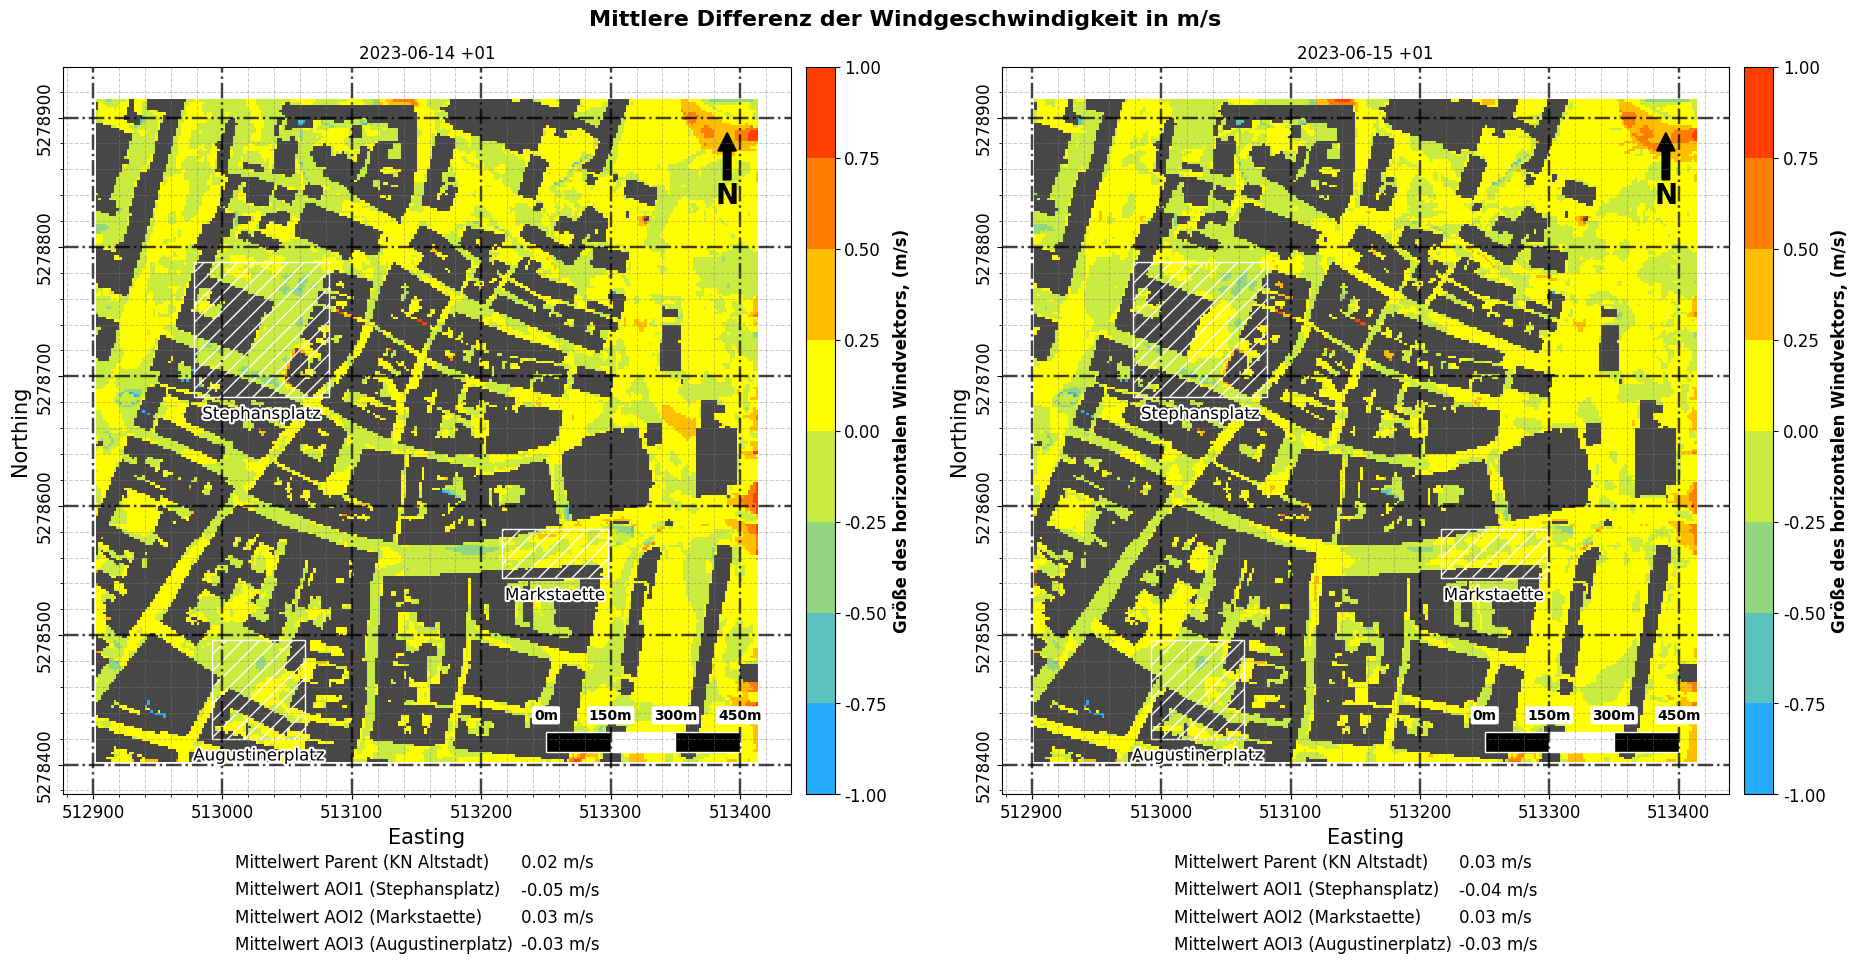

In [37]:
# Plotting the masked t_test_results using a heatmap
fig, axs = plt.subplots(1,2, figsize=(19, 9), facecolor='w', edgecolor='k')
fig.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.rcParams.update({'font.size': 15})

for i, variable_data in enumerate(list_to_plot_masked):
    ax = axs[i]
    plt.suptitle(f"Mittlere Differenz der Windgeschwindigkeit in {unit}", fontsize=16, weight='bold')

    # Define plot color and mask color
    cmap = plt.get_cmap('jet')  # Other cmap: jet, turbo, rainbow,
    cmap.set_bad('#474747')  # 474747

    # Define qualitative from sequential cmap
    num_colors = count_interval
    sequential_cmap = custom_cmap #plt.get_cmap('turbo')
    colors = [sequential_cmap(i / num_colors) for i in range(num_colors)]
    qualitative_cmap = plt.cm.colors.ListedColormap(colors)
    qualitative_cmap.set_bad('#474747')

    pcm = ax.pcolormesh(x,y, variable_data, cmap=qualitative_cmap, vmin=vmin, vmax=vmax)
    
    # Compute statistics
    values = variable_data[:,:]
    
    buffer_distance = half_window_2 = 10
    # Plot shapefile and calculate mean within each polygon
    buffered_gdf = gdf_uhi.copy()
    buffered_gdf['geometry'] = buffered_gdf['geometry'].buffer(buffer_distance, join_style=2)
    buffered_gdf.plot(ax=ax, color='none', edgecolor='w', linewidth=1.0, alpha=1, hatch='//')

    aoi_uhi_mean = []
    for index, row in gdf_uhi.iterrows():
        polygon = row.geometry
        min_x, min_y, max_x, max_y = polygon.bounds
        x1, y1, x2, y2 = int((min_x-origin_x)/dx), int((min_y-origin_y)/dx), int((max_x-origin_x)/dx), int((max_y-origin_y)/dx)

        half_window = half_window_2
        value_mean_polygon = values[y1-half_window:y2+half_window, x1-half_window:x2+half_window]
        aoi_uhi_mean.append(value_mean_polygon)
        
        ax.annotate(row['Location'], 
            xy=(polygon.centroid.x, min_y), 
            xytext=(0,-25), 
            textcoords="offset points", 
            ha='center', 
            fontsize=12,
            path_effects=[pe.withStroke(linewidth=3, foreground='white')])

    ax.grid(True, linestyle='-.', linewidth=1.75, color='k', alpha=0.75)
    ax.set_xlabel('Easting', fontsize=15)
    ax.set_ylabel('Northing', fontsize=15)
    ax.set_aspect(1)  # 1 or 'equal'

    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
    ax.xaxis.grid(which='minor', linestyle='--', linewidth=0.75, color='grey', alpha=0.4)
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
    ax.yaxis.grid(which='minor', linestyle='--', linewidth=0.75, color='grey', alpha=0.4)

    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelrotation=90, labelsize=12, )
    center_yticks(ax)

    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: f'{y:.0f}'))
    ax.set_title(f"{list_of_titles[i]}", fontsize=12)
    ax.set_xlim(x[0]-25, x[-1]+25)
    ax.set_ylim(y[0]-25, y[-1]+25)

    # Create color bar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="4%", pad=0.15)
    cb = fig.colorbar(pcm, cax=cax, extend=None, format='%.2f', spacing='uniform', )
    cb.ax.tick_params(labelsize=12, rotation=0)
    cb.ax.xaxis.set_ticks_position("top")
    cb.ax.set_ylabel(f"Größe des horizontalen Windvektors, ({unit})", fontsize=12, weight="bold")
    # locator = MultipleLocator(5)
    cb.ax.yaxis.set_major_locator(ticker.LinearLocator(numticks=count_interval+1))
    # cb.ax.tick_params(rotation=90)
    # center_yticks(cb.ax)

    # Create a table
    table_data = [
        ["Mittelwert Parent (KN Altstadt)", f"{np.nanmean(values):.2f} {unit}"],
        [f"Mittelwert AOI1 ({location_name_list[1]})",
         f"{np.nanmean(aoi_uhi_mean[0]):.2f} {unit}"],
        [f"Mittelwert AOI2 ({location_name_list[2]})",
         f"{np.nanmean(aoi_uhi_mean[1]):.2f} {unit}"],
        [f"Mittelwert AOI3 ({location_name_list[3]})",
         f"{np.nanmean(aoi_uhi_mean[2]):.2f} {unit}"]
    ]
    table = ax.table(cellText=table_data,
                     loc='bottom',
                     cellLoc='left',
                     colWidths=[0.45, 0.2],
                     edges='open',
                     bbox=[0.195, -0.225, 0.6, 0.15],)  # xmin, ymin, width, height
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    
    plot_north_arrow_and_scale_bar()
plt.show()

### Ttest

In [38]:
# Set the alpha value for the significance level
alpha_test = 0.05
t_test_results_day1 = np.zeros((256, 256))
t_test_results_day2 = np.zeros((256, 256))
t_test_results_night1 = np.zeros((256, 256))

for i in range(band_shape[1]):
    for j in range(band_shape[2]):
        values_temp_1 = []
        values_temp_2 = []

        for time_index_temp in list_day_1:
            temp_1 = band_values1[time_index_temp,i,j]
            temp_2 = band_values2[time_index_temp,i,j]
            
            values_temp_1.append(temp_1)
            values_temp_2.append(temp_2)
                    
        t_statistic, p_value_ttest = stats.ttest_ind(values_temp_1, values_temp_2)
        if p_value_ttest < alpha_test:
            # print("Reject null")
            t_test_results_day1[i,j] = 1
        else:
            t_test_results_day1[i,j] = 2
            # print("Failed to reject null")

In [39]:
for i in range(band_shape[1]):
    for j in range(band_shape[2]):
        values_temp_1 = []
        values_temp_2 = []

        for time_index_temp in list_day_2:
            temp_1 = band_values1[time_index_temp,i,j]
            temp_2 = band_values2[time_index_temp,i,j]
            
            values_temp_1.append(temp_1)
            values_temp_2.append(temp_2)
                    
        t_statistic, p_value_ttest = stats.ttest_ind(values_temp_1, values_temp_2)
        if p_value_ttest < alpha_test:
            # print("Reject null")
            t_test_results_day2[i,j] = 1
        else:
            t_test_results_day2[i,j] = 2
            # print("Failed to reject null")

In [40]:
t_test_results_list_masked = [ma.array(t_test_results_day1, mask=~buildings_2d_data.mask),
                              ma.array(t_test_results_day2, mask=~buildings_2d_data.mask)]

list_of_titles = ['2023-06-14 +01', '2023-06-15 +01']

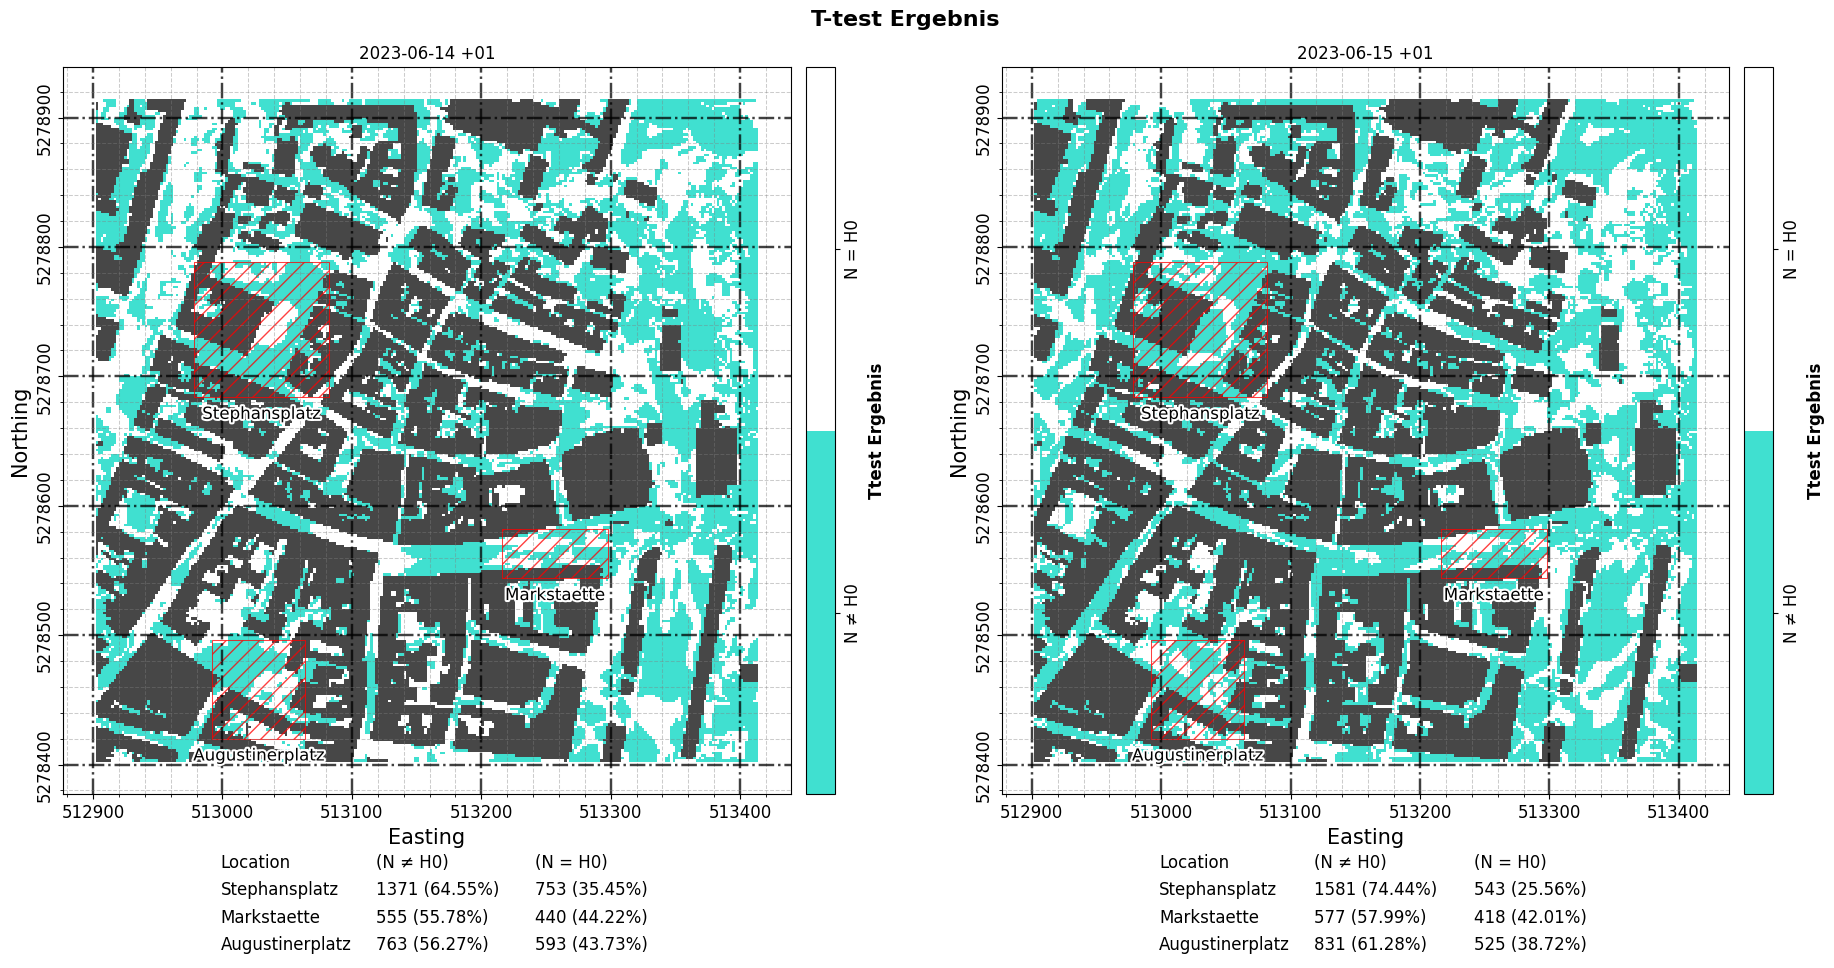

In [41]:
# Plotting the masked t_test_results using a heatmap
fig, axs = plt.subplots(1,2, figsize=(19, 9), facecolor='w', edgecolor='k')
fig.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.rcParams.update({'font.size': 15})

for i, variable_data in enumerate(t_test_results_list_masked):
    ax = axs[i]
    plt.suptitle(f"T-test Ergebnis", fontsize=16, weight='bold')
    
    cmap = lsc.from_list("CustomCmap", ['#40E0D0', '#ffffff'], N=2)
    cmap.set_bad('#474747')
    
    pcm = ax.pcolormesh(x, y, variable_data, cmap=cmap)
    
    # Compute statistics
    values = variable_data[:,:]
    
    buffer_distance = half_window_2 = 10
    # Plot shapefile and calculate mean within each polygon
    buffered_gdf = gdf_uhi.copy()
    buffered_gdf['geometry'] = buffered_gdf['geometry'].buffer(buffer_distance, join_style=2)
    buffered_gdf.plot(ax=ax, color='none', edgecolor='r', linewidth=0.75, alpha=0.75, hatch='//')
    
    count_1 = []
    count_2 = []
    count_sum = []
    for index, row in gdf_uhi.iterrows():
        polygon = row.geometry
        min_x, min_y, max_x, max_y = polygon.bounds
        x1, y1, x2, y2 = int((min_x-origin_x)/dx), int((min_y-origin_y)/dx), int((max_x-origin_x)/dx), int((max_y-origin_y)/dx)

        half_window = half_window_2
        
        values_polygon = values[y1-half_window:y2+half_window, x1-half_window:x2+half_window]
        count_ones = np.sum(values_polygon == 1)
        count_twos = np.sum(values_polygon == 2)

        count_1.append(count_ones)
        count_2.append(count_twos)
        count_sum.append(count_ones+count_twos)
        
        ax.annotate(row['Location'], 
            xy=(polygon.centroid.x, min_y), 
            xytext=(0,-25), 
            textcoords="offset points", 
            ha='center', 
            fontsize=12,
            path_effects=[pe.withStroke(linewidth=3, foreground='white')])
    
    ax.grid(True, linestyle='-.', linewidth=1.75, color='k', alpha=0.75)
    ax.set_xlabel('Easting', fontsize=15)
    ax.set_ylabel('Northing', fontsize=15)
    ax.set_aspect(1)  # 1 or 'equal'

    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
    ax.xaxis.grid(which='minor', linestyle='--', linewidth=0.75, color='grey', alpha=0.4)
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
    ax.yaxis.grid(which='minor', linestyle='--', linewidth=0.75, color='grey', alpha=0.4)

    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelrotation=90, labelsize=12, )
    center_yticks(ax)

    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: f'{y:.0f}'))
    ax.set_title(f'{list_of_titles[i]}', fontsize=12)
    ax.set_xlim(x[0]-25, x[-1]+25)
    ax.set_ylim(y[0]-25, y[-1]+25)
    
    # Create color bar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="4%", pad=0.15)
    cb = fig.colorbar(pcm, cax=cax, extend=None, format='%.2f', spacing='uniform')
    cb.ax.xaxis.set_ticks_position("top")
    cb.ax.set_ylabel("Ttest Ergebnis", fontsize=12, weight="bold")

    # Remove current ticks and set custom ticks and labels
    center_yticks(cb.ax)
    custom_ticks = [1.25, 1.75]  # Replace with your custom tick locations
    custom_labels = ['N ≠ H0', 'N = H0']  # Replace with your custom tick labels
    cb.set_ticks(custom_ticks)
    cb.set_ticklabels(custom_labels)
    cb.ax.tick_params(rotation=90)
    
    # Create a table
    table_data = [
        ["Location","(N ≠ H0)", "(N = H0)"], 
        [f"{location_name_list[1]}", f"{count_1[0]} ({(count_1[0]/count_sum[0])*100:.2f}%)", f"{count_2[0]} ({(count_2[0]/count_sum[0])*100:.2f}%)"],
        [f"{location_name_list[2]}", f"{count_1[1]} ({(count_1[1]/count_sum[1])*100:.2f}%)", f"{count_2[1]} ({(count_2[1]/count_sum[1])*100:.2f}%)"],
        [f"{location_name_list[3]}", f"{count_1[2]} ({(count_1[2]/count_sum[2])*100:.2f}%)", f"{count_2[2]} ({(count_2[2]/count_sum[2])*100:.2f}%)"],
    ]
    table = ax.table(cellText=table_data,
                     loc='bottom',
                     cellLoc='left',
                     colWidths=[0.35, 0.35, 0.45],
                     edges='open',
                     bbox=[0.195, -0.225, 0.7, 0.15],)  # xmin, ymin, width, height
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    
plt.show()